In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
activity_header = ['id', 'subject_id', 'session', 'start_time', 'end_time',
                   'rel_start_time', 'rel_end_time', 'gesture_scenario', 'task_id', 'content_id']

accelerometer_header = ['sys_time', 'event_time', 'activity_id', 'x', 'y', 'z', 'orientation']

gyroscope_header = accelerometer_header.copy()
magnetometer_header = accelerometer_header.copy()

# TODO:
# pointer count: 1 - single touch, 2 - multitouch. Ig it's better to transform it
# into 'is_multitouch' and make it 0s and 1s
touch_event_header = ['sys_time', 'event_time', 'activity_id', 'pointer_count', 'pointer_id',
                      'action_id', 'x', 'y', 'pressure', 'contact_size', 'orientation']

# activity_id and press_type should be swapped, there is a typo in dataset description
# it also seems that press_type should be reversed (1: finger down, 0: finger up)
key_press_event_header = ['sys_time', 'press_time', 'activity_id', 'press_type', 'key_id', 'orientation']

one_finger_touch_event_header = ['sys_time', 'press_time', 'activity_id', 'tap_id', 'tap_type', 'action_type',
                                 'x', 'y', 'pressure', 'contact_size', 'orientation']

pinch_event_header = ['sys_time', 'press_time', 'activity_id', 'event_type', 'pinch_id', 'time_delta',
                      'x_focus', 'y_focus', 'span', 'span_x', 'span_y', 'scale_factor', 'orientation']

scroll_event_header = ['sys_time', 'begin_time', 'current_time', 'activity_id', 'scroll_id', 'start_action_type',
                       'start_x', 'start_y', 'start_pressure', 'start_size', 'current_action_type',
                       'current_x', 'current_y', 'current_pressure', 'current_size', 'distance_x', 'distance_y',
                       'orientation']

stroke_event_header = ['sys_time', 'begin_time', 'end_time', 'activity_id', 'start_action_type', 'start_x', 'start_y',
                       'start_pressure', 'start_size', 'end_action_type', 'end_x', 'end_y', 'end_pressure', 'end_size',
                       'speed_x', 'speed_y', 'orientation']

In [5]:
subject_1_path = 'hmog_public_dataset/100669'
subject_1_sess_1_path = '100669_session_1'

In [7]:
activity_csv = pd.read_csv(f'{subject_1_path}/{subject_1_sess_1_path}/Activity.csv', names=activity_header)

In [8]:
activity_csv.head()

# end_time - start_time == rel_end_time - rel_start_time
# rel is relative to sys boot
# others are absolute

,id,subject_id,session,start_time,end_time,rel_start_time,rel_end_time,gesture_scenario,task_id,content_id
0,100669011000001,100669,1,1396226213027,1396226407573,6792617,6987163,1,7,1
1,100669012000001,100669,1,1396226421894,1396226578198,7001484,7157788,1,7,2
2,100669012000002,100669,1,1396226600720,1396226650781,7180310,7230371,1,7,2
3,100669012000002,100669,1,1396226600720,1396226653876,7180310,7233466,1,7,2
4,100669012000003,100669,1,1396226672419,1396226737648,7252008,7317238,1,7,2


## Data Preprocessing

I think it's worth creating helper functions that read given paths, preprocess, and combine the data

In [6]:
import os

def check_session_typing(path_to_session: str):
    # We are interested in sessions 3, 9, 15, 21 for w+s
    # and 4, 10, 16, 22 for w+w
    typing_task_ids = [3, 9, 15, 21, 4, 10, 16, 22]

    activity_df = pd.read_csv(os.path.join(path_to_session, 'Activity.csv'), names=activity_header)

    if activity_df['task_id'][0] in typing_task_ids:
        return True
    return False

def list_user_typing_sessions(path_to_sessions: str):
    session_folders = os.listdir(path_to_sessions)
    session_folders = [f for f in session_folders if not os.path.isfile(os.path.join(path_to_sessions, f))]

    typing_session_folders = []
    for session_folder in session_folders:
        if check_session_typing(os.path.join(path_to_sessions, session_folder)):
            typing_session_folders.append(session_folder)

    return typing_session_folders

In [7]:
# A test for a single! user
typing_sessions_user = list_user_typing_sessions(subject_1_path)

print(typing_sessions_user)

['100669_session_22', '100669_session_24', '100669_session_2', '100669_session_3', '100669_session_19', '100669_session_18', '100669_session_8', '100669_session_9']


In [90]:
import os
import pandas as pd
import numpy as np

def read_person_session(path_to_session: str):
    activity_csv = pd.read_csv(os.path.join(path_to_session, 'Activity.csv'), names=activity_header)
    accelerometer_csv = pd.read_csv(os.path.join(path_to_session, 'Accelerometer.csv'), names=accelerometer_header)
    gyroscope_csv = pd.read_csv(os.path.join(path_to_session, 'Gyroscope.csv'), names=gyroscope_header)
    key_press_event_csv = pd.read_csv(os.path.join(path_to_session, 'KeyPressEvent.csv'), names=key_press_event_header)
    magnetometer_csv = pd.read_csv(os.path.join(path_to_session, 'Magnetometer.csv'), names=magnetometer_header)
    one_finger_touch_csv = pd.read_csv(os.path.join(path_to_session, 'OneFingerTouchEvent.csv'), names=one_finger_touch_event_header)
    pinch_event_csv = pd.read_csv(os.path.join(path_to_session, 'PinchEvent.csv'), names=pinch_event_header)
    scroll_event_csv = pd.read_csv(os.path.join(path_to_session, 'ScrollEvent.csv'), names=scroll_event_header)
    stroke_event_csv = pd.read_csv(os.path.join(path_to_session, 'StrokeEvent.csv'), names=stroke_event_header)
    touch_event_csv = pd.read_csv(os.path.join(path_to_session, 'TouchEvent.csv'), names=touch_event_header)

    session_map = {"activity": activity_csv,
                   "accelerometer": accelerometer_csv,
                   "gyroscope": gyroscope_csv,
                   "key_press_event": key_press_event_csv,
                   "magnetometer": magnetometer_csv,
                   "one_finger_touch": one_finger_touch_csv,
                   "pinch_event": pinch_event_csv,
                   "scroll_event": scroll_event_csv,
                   "stroke_event": stroke_event_csv,
                   "touch_event": touch_event_csv}
    
    return session_map

def preprocess_session_data(session_map: dict):
    # Activity
    pass

def compute_t_min(sensor_data, value_of: str, t_end_timestamp: int, avg100msBefore: float):
    TIME_AFTER_END_OFFSET = 200  # ms

    sensor_data = sensor_data[(sensor_data['sys_time'] >= t_end_timestamp) & (sensor_data['sys_time'] <= t_end_timestamp + TIME_AFTER_END_OFFSET)]

    n = len(sensor_data.index)
    avgDiffs = np.empty(n)
    sums = np.zeros(n)

    # Indices are not updated after taking a slice of a dataframe!
    sums[n - 1] = abs(sensor_data.iloc[n - 1][value_of] - avg100msBefore)
    for index, entry in sensor_data.iloc[::-1].iterrows():
        index = index - sensor_data.index[0]  # TODO: optimize?

        if index < n - 1:
            sums[index] = abs(entry[value_of] - avg100msBefore) + sums[index + 1]
    
    min_index = 0
    min_val = 10000000
    for i in range(n):
        avgDiffs[i] = sums[i] / (n - i)

        if avgDiffs[i] < min_val:
            min_val = avgDiffs[i]
            min_index = i
            # print(f'min_index, min_val: {min_index}, {min_val}')

    min_index = np.argmin(avgDiffs)
    return sensor_data.iloc[min_index]['sys_time']

def extract_hmog_for_keypress(sensor_data, key_down_timestamp: int, key_up_timestamp: int, value_of: str):
    TIME_BEFORE_BOUNDARY = 100  # ms
    TIME_AFTER_BOUNDARY = 100   # ms

    vals_before = []
    vals_during = []
    vals_after = []

    sensor_data = sensor_data[(sensor_data['sys_time'] >= key_down_timestamp - TIME_BEFORE_BOUNDARY) & (sensor_data['sys_time'] <= key_up_timestamp + TIME_AFTER_BOUNDARY)]

    for _, entry in sensor_data.iterrows():
        if entry['sys_time'] >= key_down_timestamp - TIME_BEFORE_BOUNDARY and entry['sys_time'] < key_down_timestamp:
            vals_before.append(entry[value_of])
        elif entry['sys_time'] >= key_down_timestamp and entry['sys_time'] <= key_up_timestamp:
            vals_during.append(entry[value_of])
        elif entry['sys_time'] > key_up_timestamp and entry['sys_time'] <= key_up_timestamp + TIME_AFTER_BOUNDARY:
            vals_after.append(entry[value_of])
    
    # HMOG features
    #
    # "Grasp Resistance"
    # 1. Mean during taps
    mean_during = sum(vals_during) / len(vals_during)
    # 2. Standard deviation during taps
    std_deviation_during = ( sum([(x - mean_during) ** 2 for x in vals_during]) / len(vals_during) ) ** 0.5
    # 3. avg100msAfter - avg100msBefore
    avg100msAfter = sum(vals_after) / len(vals_after)
    avg100msBefore = sum(vals_before) / len(vals_before)
    print(f'avg100msBefore: {avg100msBefore}')

    diff_readings = avg100msAfter - avg100msBefore

    # 4. avgTap - avg100msBefore
    net_change = mean_during - avg100msBefore
    # 5. max change during tap
    max_change_during = max(vals_during) - avg100msBefore

    #
    # "Grasp Stability"
    # TODO: finish
    # 1
    t_min = compute_t_min(sensor_data, value_of, key_up_timestamp, avg100msBefore)
    time_to_stabilize = t_min - key_up_timestamp

    # 2



    return [mean_during, std_deviation_during, diff_readings, net_change, max_change_during]


# This can be optimised, for now this is coded to present everything as simple as possible
# value_of: x, y, z
def extract_hmog_features(session_map: dict, sensor: str, value_of: str):
    # "Grasp Resistance" features

    PRESS_TYPE_DOWN = 1
    PRESS_TYPE_UP = 0

    hmog_vectors = []

    for key_press_event_index in range(len(session_map['key_press_event']) - 1):
        event = session_map['key_press_event'].iloc[key_press_event_index]
        event_down_time = event['sys_time']

        if event['press_type'] == PRESS_TYPE_DOWN:
            next_event = session_map['key_press_event'].iloc[key_press_event_index + 1]

            # Let's focus on cases when user lifts the finger before pressing another key
            if next_event['press_type'] != PRESS_TYPE_UP:
                continue
            
            event_up_time = next_event['sys_time']
            tap_hmog_vector_x = extract_hmog_for_keypress(session_map[sensor], event_down_time, event_up_time, value_of)

            hmog_vectors.append(tap_hmog_vector_x)
    
    return hmog_vectors

In [9]:
session_map = read_person_session(os.path.join(subject_1_path, typing_sessions_user[1]))

In [10]:
taps_x = extract_hmog_features(session_map, 'accelerometer', 'x')

In [11]:
print(taps_x)
print(len(taps_x))

[[-0.2617375502380953, 0.29252386496728233, 0.3598485282999999, 0.2619940827619046, 0.635062013], [-0.431811380952381, 0.21817991768719708, -0.32591070135, -0.16509730530238093, 0.14041993565000005], [-0.057149588919999966, 0.5993932060445785, 0.9487024290000001, 0.5422986710800001, 1.44160872], [0.5020797133478262, 0.2837878166787097, -0.4476425567777778, -0.2555521044299516, 0.13121558222222218], [-0.029144801038461548, 0.24797818440762345, -0.3242281143333333, -0.08953188837179489, 0.32328375266666665], [0.10639832768, 0.33257316342052906, 0.9616800762909091, 0.009732434880000002, 0.9962872071999999], [-1.1019585331818185, 0.36696517491676645, 0.2732981099999997, 0.0972372368181813, 0.5102642699999997], [-0.7636505870833332, 0.24318221789426198, 0.8199542360000001, 0.3449246589166668, 0.692582686], [-0.0011472197916666677, 0.36436078066408395, -0.3236362101, -0.34884516129166665, 0.37714665849999995], [0.06289767350000001, 0.2931700245639351, 0.2682703009, 0.17249225559999998, 0.500

In [58]:
# This is just to make sure I understood session duration correctly
def calculate_session_duration(session_id):
    session_duration = 0  # ms

    for session, start_time, end_time in zip(session_map["activity"]["session"], session_map["activity"]["start_time"], session_map["activity"]["end_time"]):
        if session == session_id:
            session_duration += end_time - start_time
        else:
            print(session)

    return session_duration / 1000 / 60  # minutes

In [59]:
print(calculate_session_duration(1))

12.204133333333335


# Tests

avg100msBefore: -0.5237316329999999
1396656030600.0


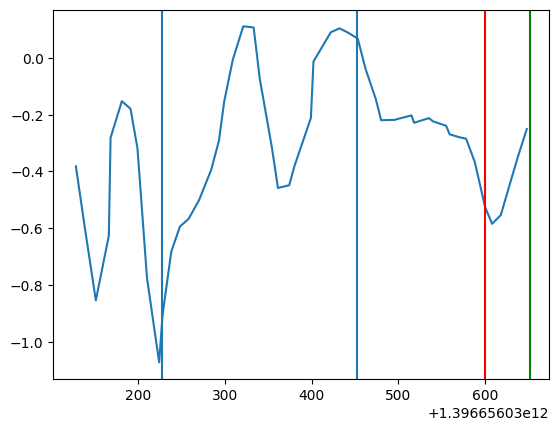

In [91]:
# Some visualisations

PRESS_TYPE_DOWN = 1
PRESS_TYPE_UP = 0

TIME_BEFORE_OFFSET = 100  # ms
TIME_AFTER_OFFSET  = 200  # ms

test_sensor = 'accelerometer'
test_value = 'x'

hmog_vectors = []
for key_press_event_index in range(len(session_map['key_press_event']) - 1):
    event = session_map['key_press_event'].iloc[key_press_event_index]
    event_down_time = event['sys_time']

    if event['press_type'] == PRESS_TYPE_DOWN:
        next_event = session_map['key_press_event'].iloc[key_press_event_index + 1]

        # Let's focus on cases when user lifts the finger before pressing another key
        if next_event['press_type'] != PRESS_TYPE_UP:
            continue
        
        event_up_time = next_event['sys_time']
        tap_hmog_vector_x = extract_hmog_for_keypress(session_map[test_sensor], event_down_time, event_up_time, test_value)

        hmog_vectors.append(tap_hmog_vector_x)

        timeframe = session_map[test_sensor][(session_map[test_sensor]['sys_time'] >= event_down_time - TIME_BEFORE_OFFSET) & (session_map[test_sensor]['sys_time'] <= event_up_time + 200)]
        t_min = compute_t_min(session_map[test_sensor], test_value, event_up_time, -0.5237316329999999)
        print(t_min)
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(timeframe['sys_time'], timeframe[test_value])
        ax.axvline(x=t_min, color='red')
        ax.axvline(x=event_down_time)
        ax.axvline(x=event_up_time)
        ax.axvline(x=event_up_time + 200, color='green')

        break

In [83]:
some_df = pd.DataFrame([5, 1, 3, 4, 7, 2])
print(some_df)

another_df = some_df[some_df[0] % 2 == 0]
print(another_df)

print(another_df.index[0])

   0
0  5
1  1
2  3
3  4
4  7
5  2
   0
3  4
5  2
3
